In [1]:
!pip install ipdb #For debugging
!pip install tqdm #For the progress bar
!pip install numpy matplotlib tensorflow
!pip install jax jaxlib #Install jax and jaxlib, which stax depends on.
!pip install -U stax #Reinstall stax to ensure the latest version
!pip install --upgrade neural-tangents #Update neural-tangents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.3 MB/s eta 0:00:00
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11232 sha256=462d55935738a2eafebaa4bdf84f703a37d0de2452f0d81e58f6dea324718cc3
  Stored in directory: /root/.cache/pip/wheels/2e/b1/0a/62566170555f623c8327d47df1f53b6e4311ec9dd0ea70a99c
Successfully built halo
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 7.5 MB/s eta 0:00:00


In the next cell we generate a plot of N=100 trained NNs and the mean and covariance of the GP at time t=epochs*learning_rate, both over a test set of 50 points.
The training set consists by default of 2 points so that the training fit is noticeable.

Using device: cpu
Epochs > 0, using finite time GP mean and covariance with t=10000.0.


Training Networks: 100%|██████████| 100000/100000 [01:44<00:00, 956.66it/s]


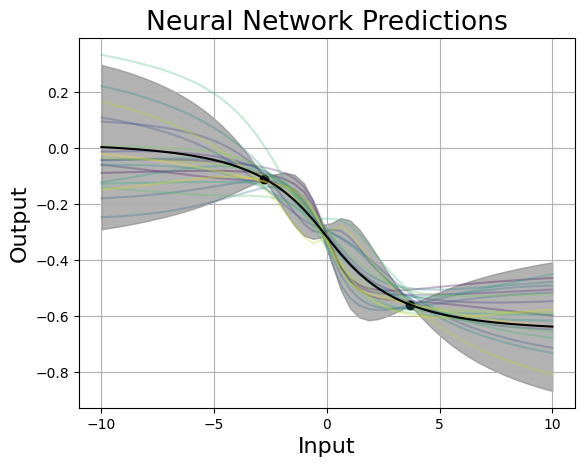

----------------------------------------
Plot Information:
  Activation Function: sigmoid
  Number of Networks: 20
  Hidden Units: 100
  Epochs: 100000
  Learning Rate: 0.1
  Training Data Seed: 5
----------------------------------------


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

import jax.numpy as jnp
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax
from neural_tangents import stax, monte_carlo_kernel_fn #To approximate tanh in stax.serial

from tqdm import tqdm # Use standard tqdm, works in notebooks and scripts

# Generate 1-dimensional training data, set hyperparameters
activation_function = 'sigmoid'   # available options: 'relu', 'erf', 'sigmoid'
num_samples = 2                   # cardinality of training set
num_networks = 20                 # Number of networks to plot
hidden_units = 100                # Width of the hidden layer (n_1 in the paper)
learning_rate = 0.1
scaled_lr = learning_rate / hidden_units  #Scaling as in [Lee et al. '19, Appendix H]
epochs = 100000
time_param = learning_rate * epochs       #Unscaled time for GP calculation

# Set a seed for reproducible training data generation
training_data_seed = 5
np.random.seed(training_data_seed)

# Generate training set
x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)  # Example function to learn
# Generate test set
x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

optimizer_type = 'sgd'      # Stochastic gradient descent

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- PyTorch Batched Shallow NN ---
class BatchedShallowNN_Pytorch(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, W_std=1.0, B_std=0.0):
        super(BatchedShallowNN_Pytorch, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units

        # Parameters will have an extra dimension for num_parallel_networks
        # Layer 1 weights and biases
        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * W_std)
        self.b1 = nn.Parameter(torch.zeros(num_parallel_networks, hidden_units))

        # Layer 2 weights and biases
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * W_std)
        self.b2 = nn.Parameter(torch.zeros(num_parallel_networks, 1) * B_std)

        #Activation function selection
        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf # Assign the function itself, not the result of calling it since its not an nn module

        # NTK Scaling factor
        self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

    def forward(self, x):
        # Hidden layer computation
        # (N, H, D_in) @ (B, D_in).T = (N, H, D_in) @ (D_in, B) -> (N, H, B)
        # N = num_parallel_networks, H = hidden_units, D_in = input_dim, B = batch_size_data
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2) # unsqueeze for broadcasting over data batch
        hidden_act = self.activation(hidden_lin)

        # Output layer computation
        # (N, O, H) @ (N, H, B) -> (N, O, B) where O=1 (output_dim)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)

        # NTK Scaling
        outputs_scaled = outputs_lin / self.ntk_scale

        # Reshape to (num_parallel_networks, batch_size_data, output_dim)
        # Current shape is (num_parallel_networks, output_dim, batch_size_data)
        return outputs_scaled.transpose(1, 2)

# --- Train Batched PyTorch Networks ---
def train_batched_networks_pytorch(width, num_parallel_train_networks,
                                   x_train_np_local, y_train_np_local, x_test_np_local,
                                   epochs_local, lr_local, current_device):

    model = BatchedShallowNN_Pytorch(input_dim=x_train_np_local.shape[1],
                                     hidden_units=width,
                                     num_parallel_networks=num_parallel_train_networks).to(current_device)

    x_train_torch = torch.from_numpy(x_train_np_local).float().to(current_device)
    y_train_torch = torch.from_numpy(y_train_np_local).float().to(current_device)
    x_test_torch = torch.from_numpy(x_test_np_local).float().to(current_device)

    if epochs_local > 0:
        optimizer = optim.SGD(model.parameters(), lr=lr_local)
        criterion = nn.MSELoss()

        # Expand y_train to match batched output shape: (num_parallel_networks, batch_size_data, output_dim)
        y_train_expanded = y_train_torch.unsqueeze(0).expand(num_parallel_train_networks, -1, -1)

        model.train()
        for epoch_idx in tqdm(range(epochs_local), desc="Training Networks"): # Add tqdm here
            optimizer.zero_grad()
            outputs = model(x_train_torch) # Shape: (num_parallel, batch_data, out_dim)
            loss = criterion(outputs, y_train_expanded) # Will average over all N*B*O elements
            loss.backward()
            optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_batched = model(x_test_torch) # Shape: (num_parallel, batch_test_data, out_dim)

    # Return as numpy array, flatten last two dims if output_dim is 1
    # Shape: (num_parallel_train_networks, num_test_inputs)
    return predictions_batched.cpu().numpy().reshape(num_parallel_train_networks, -1)

# --- It function ---
def It(k, t):
    # Add a small diagonal jitter to handle singularity
    k_reg = k + np.eye(k.shape[0]) * 1e-6
    t = t*scaled_lr   #Accounting for NTK scaling
    # Solve linear system kX = I - e^{-kt}
    b_matrix = np.identity(k_reg.shape[0]) - scipy.linalg.expm(-k_reg * t)
    return np.linalg.solve(k_reg, b_matrix)

# --- GP Calculation ---
# Width in stax.Dense is just a placeholder for NTK computation, doesn't affect the kernel value for infinite width limit
# kernel_fn is stateless, so safe to define once
# Select activation function for NTK computation
if activation_function == 'sigmoid':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'relu':
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )
elif activation_function == 'erf':  # Using built-in stax.Erf
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(10, W_std=1.0, b_std=0.0), stax.Erf(),
        stax.Dense(1, W_std=1.0, b_std=0.0)
    )

# Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

# Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
k2_test_test = np.array(k2_test_test_jax.block_until_ready())
k2_test_train = np.array(k2_test_train_jax.block_until_ready())
k2_train_test = np.array(k2_train_test_jax.block_until_ready())
k2_train_train = np.array(k2_train_train_jax.block_until_ready())

kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
# kinf_train_test is just kinf_test_train.T
kinf_train_test = kinf_test_train.T

# GP mean and covariance calculation
if epochs == 0: # At initialization
    gp_mean = np.zeros_like(x_test @ y_train.T)
    gp_cov = k2_test_test
    print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

else: # epochs > 0
    Itk = It(kinf_train_train, time_param)      # Use unscaled time
    gp_mean = kinf_test_train @ Itk @ y_train

    pz1 = k2_test_test
    pz2 = -k2_test_train @ Itk @ kinf_train_test
    pz3 = -kinf_test_train @ Itk @ k2_train_test
    pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
    gp_cov = pz1 + pz2 + pz3 + pz4
    print(f"Epochs > 0, using finite time GP mean and covariance with t={time_param}.")

# Ensure gp_cov is positive semi-definite for sampling
gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6

gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

# Train/evaluate batched networks
# Note: We are not setting a seed for the PyTorch model initialization here.
# To make network initialization reproducible, you would also need to set torch.manual_seed()
# before creating the BatchedShallowNN_Pytorch instance.
nn_outputs = train_batched_networks_pytorch(
    width=hidden_units,
    num_parallel_train_networks=num_networks,
    x_train_np_local=x_train,
    y_train_np_local=y_train,
    x_test_np_local=x_test,
    epochs_local=epochs,
    lr_local=scaled_lr,
    current_device=device
)

# Create a colormap for the network predictions
cmap = plt.get_cmap('viridis')                  # Choose a colormap you like
colors = cmap(np.linspace(0, 1, num_networks))  # Generate colors for each network
# Plot individual network predictions
for i in range(num_networks):
    plt.plot(x_test, nn_outputs[i], color=colors[i], alpha=0.3)  # Adjust color and alpha as desired

# Plot the GP mean and std
plt.plot(x_test, gp_mean, color='black', label='GP Mean')
plt.fill_between(
    x_test.ravel(),
    gp_mean[:, 0].ravel() - 2*gp_std,  # Select the first output column
    gp_mean[:, 0].ravel() + 2*gp_std,  # Select the first output column
    color='gray',
    alpha=0.6,
    label='GP 95% Confidence Interval'
)
# Plot training data
font = 16
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.rcParams.update({'font.size': font})
plt.title('Neural Network Predictions')
plt.xlabel('Input', fontsize=font)
plt.ylabel('Output',fontsize=font)
plt.grid(True)

plt.show()

# Print plot_info in a formatted way
print("-" * 40)
print("Plot Information:")
print(f"  Activation Function: {activation_function}")
print(f"  Number of Networks: {num_networks}")
print(f"  Hidden Units: {hidden_units}")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Training Data Seed: {training_data_seed}") # Print the seed used
print("-" * 40)  # Print a separator line

For testing and hyperparameter tuning purposes, the next cells produce an animation of the networks during the training and a plot of the GP mean and covariance for different choices of the number of epochs, respectively.
In both plots the learning rate is fixed (specified in previous cell).

In [ ]:
#ANIMATION OF NETWORKS DURING TRAINING
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Set up parameters for the animation (re use parameters from first cell)
# learning_rate = 0.01
num_networks = 5  # Number of networks to animate
epochs_per_frame = 500  # Number of epochs to train per frame
total_frames = 100  # Total number of frames in the animation
  # So in this cell epochs = epochs_per_frame * total_frames
  # No need to calculate time_param since we are not plotting the GP

# Generate training data (same as before)
#x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1))
#y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1)
# Generate data for plotting (same as before)
#x_test = np.linspace(-10, 10, 50).reshape(-1, 1)

# Create the figure and axes for the animation
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color='black', label='Training Data')
lines = [ax.plot([], [], label=f'Network {i + 1}')[0] for i in range(num_networks)]
ax.set_xlim([-10, 10])
ax.set_ylim([-2, 2])
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Neural Network Predictions')
ax.legend()
ax.grid(True)

# Define the animation function
def animate(frame):
    epochs = frame * epochs_per_frame
    nn_outputs = train_batched_networks_pytorch(
        width=hidden_units,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train,
        y_train_np_local=y_train,
        x_test_np_local=x_test,
        epochs_local=epochs,  # Use the accumulated epochs
        lr_local=scaled_lr,
        current_device=device
    )
    for i, line in enumerate(lines):
        line.set_data(x_test, nn_outputs[i])
    ax.set_title(f'Neural Network Predictions (Epoch {epochs})')
    return lines

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=total_frames, blit=True, interval=100)

# Display the animation (in Colab, you might need to use HTML)
from IPython.display import HTML
HTML(ani.to_jshtml())

Training Networks: 100%|█████████▉| 31367/31500 [00:29<00:00, 1211.86it/s]

Epochs =  100 using finite time GP mean and covariance with t=10.0.
Epochs =  500 using finite time GP mean and covariance with t=50.0.
Epochs =  1000 using finite time GP mean and covariance with t=100.0.
Epochs =  5000 using finite time GP mean and covariance with t=500.0.
Epochs =  10000 using finite time GP mean and covariance with t=1000.0.
Epochs =  50000 using finite time GP mean and covariance with t=5000.0.


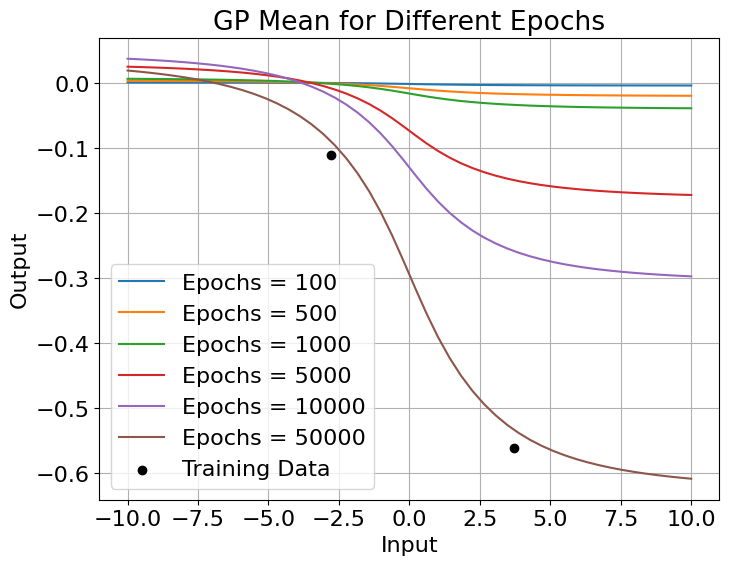

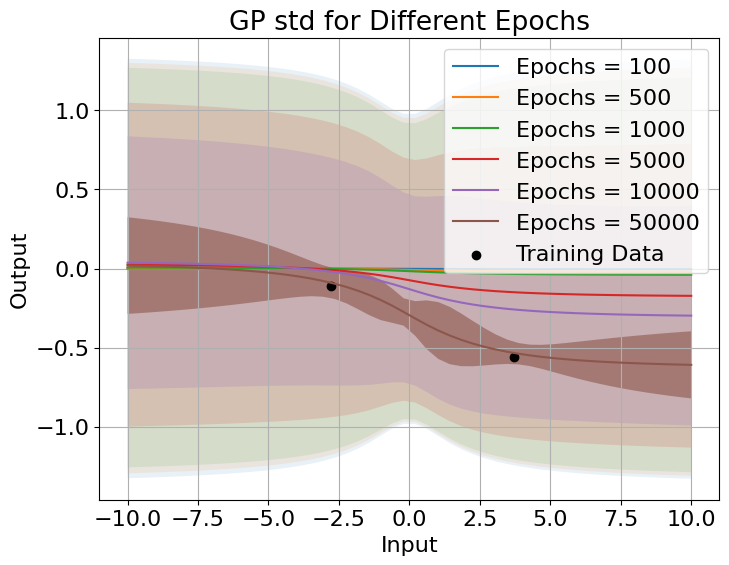

In [ ]:
#PLOTS OF GP FOR DIFFERENT EPOCHS
# Re use parameters from previous cells

# Select different epochs for testing

#my_range = [10, 50, 100, 500, 1000, 5000, 10000]
#my_range = [0,50,100,500,1000]
my_range = [100,500,1000,5000,10000,50000]
#x_train = np.random.uniform(low=-5, high=5, size=(4, 1))
#y_train = np.sin(x_train) + 0.1 * np.random.randn(4, 1)  # Example function to learn

gp_means_epochs = []
gp_stds_epochs = [] # Store standard deviations as well

for ran in my_range:
    # GP calculation
    # Select activation function for NTK computation
    if activation_function == 'sigmoid':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'relu':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'erf':  # Using built-in stax.Erf
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(100, W_std=1.0, b_std=0.0), stax.Erf(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )

    # Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
    k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
    k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
    k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
    k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

    kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
    kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

    # Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
    k2_test_test = np.array(k2_test_test_jax.block_until_ready())
    k2_test_train = np.array(k2_test_train_jax.block_until_ready())
    k2_train_test = np.array(k2_train_test_jax.block_until_ready())
    k2_train_train = np.array(k2_train_train_jax.block_until_ready())

    kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
    kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
    # kinf_train_test is just kinf_test_train.T
    kinf_train_test = kinf_test_train.T

    # GP mean and covariance calculation
    # Ensure time is non-zero if epochs > 0, otherwise Itk might be ill-defined or zero.
    # If epochs=0, learning_rate*epochs = 0. expm(0) = I. So I - I = 0. Itk -> 0.
    # This means gp_mean becomes 0 if epochs=0 and lr*epochs is the time.
    # The theory for t=0 (initialization) is simpler:
    # Mean_t0 = 0 (if biases are 0 and centered weights)
    # Cov_t0 = NNGP kernel (k2_test_test - k2_test_train @ k2_train_train_inv @ k2_train_test)
    # The provided formula is for finite time t > 0 with gradient descent.

    if ran == 0: # At initialization
        gp_mean = np.zeros_like(x_test @ y_train.T)
        gp_cov = k2_test_test
        print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

    else: # epochs > 0
        Itk = It(kinf_train_train, ran * learning_rate) # Use ran * learning_rate as time_param
        gp_mean = kinf_test_train @ Itk @ y_train

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4
        print("Epochs = ", str(ran), f"using finite time GP mean and covariance with t={ran * learning_rate}.")


    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-6

    gp_std = np.sqrt(np.diag(gp_cov)) # Calculating gp_std from gp_cov

    # ... #
    gp_means_epochs.append(gp_mean)
    gp_stds_epochs.append(gp_std) # Store stds


plt.figure(figsize=(8, 6))  # Adjust figure size as desired
for i, epochs_val in enumerate(my_range):
    plt.plot(x_test, gp_means_epochs[i], label=f'Epochs = {epochs_val}')
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.title('GP Mean for Different Epochs')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))  # Adjust figure size as desired

#For plotting with transparencies:
max_epoch = np.max(my_range)
for i, epochs_val in enumerate(my_range):

    # Use the mean and std from the corresponding epoch value
    current_mean = gp_means_epochs[i]
    current_std = gp_stds_epochs[i]
    plt.plot(x_test, current_mean, label=f'Epochs = {epochs_val}')
    plt.fill_between(
        x_test.ravel(),
        current_mean[:, 0] - 1.96 * current_std, # Select the first column to match std shape
        current_mean[:, 0] + 1.96 * current_std, # Select the first column to match std shape
        alpha= 0.1 + epochs_val / (2*max_epoch),  # Adjust alpha for transparency
    )
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.title('GP std for Different Epochs')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

Now let us plot the evolution of both the networks and the GP when increasing $n_1$.

Training networks with width: 10


Training Networks: 100%|██████████| 50000/50000 [00:52<00:00, 952.13it/s] 


Training networks with width: 20


Training Networks: 100%|██████████| 50000/50000 [00:54<00:00, 920.91it/s]


Training networks with width: 50


Training Networks: 100%|██████████| 50000/50000 [00:54<00:00, 918.62it/s]


Training networks with width: 100


Training Networks: 100%|██████████| 50000/50000 [00:56<00:00, 887.27it/s]


Training networks with width: 200


Training Networks: 100%|██████████| 50000/50000 [01:00<00:00, 821.75it/s]


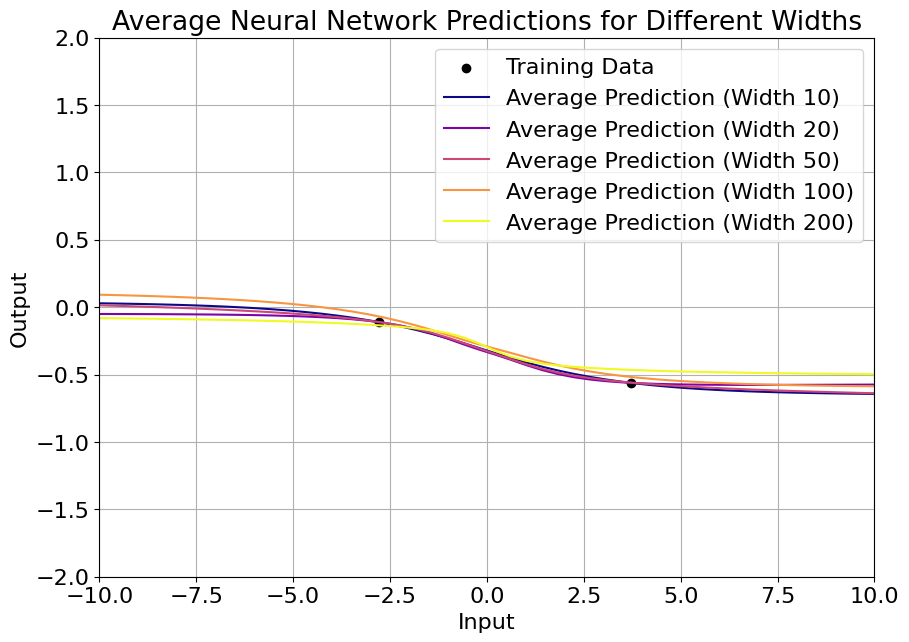

In [ ]:
# PLOT OF NETWORKS FOR DIFFERENT WIDTHS - Averaged Predictions
import matplotlib.pyplot as plt
import numpy as np
import torch

# learning_rate = 0.01 # Using learning_rate defined in the previous cell
# epochs = 7000 # Using epochs defined in the previous cell
num_networks = 10  # Number of networks to average
my_range = [10,20,50,100,200] # Widths to test

#Scale consequently the learning rates:
my_lrs = learning_rate / np.array(my_range)

# Generate training data (same as before)
#x_train = np.random.uniform(low=-5, high=5, size=(num_samples, 1)) # Using x_train from previous cell
#y_train = np.sin(x_train) + 0.1 * np.random.randn(num_samples, 1) # Using y_train from previous cell
# Generate data for plotting (same as before)
#x_test = np.linspace(-10, 10, 50).reshape(-1, 1) # Using x_test from previous cell

plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, color='black', label='Training Data')

# Create a colormap for the different widths
cmap_widths = plt.get_cmap('plasma') # Or any other colormap
colors_widths = cmap_widths(np.linspace(0, 1, len(my_range)))

# Loop through different widths and plot network predictions
for i, current_width in enumerate(my_range):
    print(f"Training networks with width: {current_width}")
    nn_outputs = train_batched_networks_pytorch(
        width=current_width,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train,
        y_train_np_local=y_train,
        x_test_np_local=x_test,
        epochs_local=epochs, # Use the global epochs
        #lr_local=learning_rate, # Use the global learning_rate
        lr_local = my_lrs[i],
        current_device=device # Use the global device
    )

    # Calculate the average prediction across the networks
    average_prediction = np.mean(nn_outputs, axis=0)

    # Plot the average prediction for the current width
    plt.plot(x_test.ravel(), average_prediction, color=colors_widths[i], label=f'Average Prediction (Width {current_width})')

plt.xlim([-10, 10])
plt.ylim([-2, 2])
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Average Neural Network Predictions for Different Widths')
plt.legend()
plt.grid(True)
plt.show()